# 1. Objetivo

La idea del proycto es realizar una clasificación de imágenes en tres clases -> Frutas, Vegetales y Paquetes.

#### data set reference
```
  title={A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels},
  author={Klasson, Marcus and Zhang, Cheng and Kjellstr{\"o}m, Hedvig},
  booktitle={IEEE Winter Conference on Applications of Computer Vision (WACV)},
  year={2019}
```

## Un puntapie de inicio

In [64]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

#### Vamos a crear algunas funciones útiles

In [65]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  


# 2. Descarga y Armado del dataset

In [66]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [67]:
## fijamos los paths
train_path = './GroceryStoreDataset/dataset/train' 
validation_path = './GroceryStoreDataset/dataset/val'
test_path = './GroceryStoreDataset/dataset/test'

In [68]:
!dir ./GroceryStoreDataset/dataset/train/Fruit

Apple	 Kiwi	Mango	   Orange	  Peach      Plum	     Satsumas
Avocado  Lemon	Melon	   Papaya	  Pear	     Pomegranate
Banana	 Lime	Nectarine  Passion-Fruit  Pineapple  Red-Grapefruit


## 2.2 Preprocesamiento inicial de los datos¿
Creamos algunos preprocesamientos sin ningun variación ni aumento de los datos. Este es el comienzo :)

In [69]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 8)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [70]:
train_batches

In [71]:
#take a look at output of the generators
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)


# 3. Crear un Modelo base Convolusional

In [72]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(96, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 96)                37850208  
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 291       
Total params: 37,851,395
Trainable params: 37,851,395
Non-trainable params: 0
_________________________________________________________________


In [73]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=5,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/5
83/82 [==============================] - 9s 108ms/step - loss: 294.4330 - acc: 0.5095 - val_loss: 235.3804 - val_acc: 0.4696
Epoch 2/5
83/82 [==============================] - 9s 106ms/step - loss: 95.9128 - acc: 0.6186 - val_loss: 166.2210 - val_acc: 0.4628
Epoch 3/5
83/82 [==============================] - 9s 105ms/step - loss: 62.1126 - acc: 0.6561 - val_loss: 106.8386 - val_acc: 0.5473
Epoch 4/5
83/82 [==============================] - 9s 105ms/step - loss: 37.0060 - acc: 0.7242 - val_loss: 41.0497 - val_acc: 0.5946
Epoch 5/5
83/82 [==============================] - 9s 105ms/step - loss: 20.1341 - acc: 0.7765 - val_loss: 27.0523 - val_acc: 0.5743


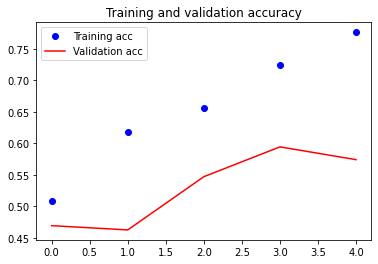

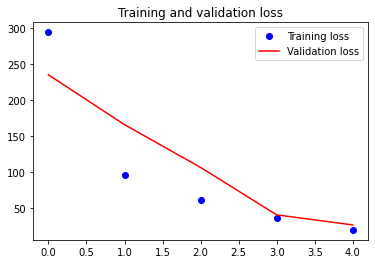

In [74]:

import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Confusion matrix, without normalization
[[556 359 202]
 [377 267 137]
 [273 193 121]]
              precision    recall  f1-score   support

       Fruit       0.46      0.50      0.48      1117
    Packages       0.33      0.34      0.33       781
  Vegetables       0.26      0.21      0.23       587

    accuracy                           0.38      2485
   macro avg       0.35      0.35      0.35      2485
weighted avg       0.37      0.38      0.37      2485



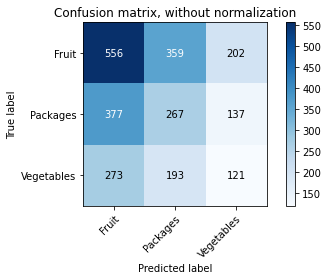

In [75]:
from sklearn.metrics import confusion_matrix
from matplotlib import cm
y_true = test_batches.labels
y_pred = model.predict_classes(test_batches)
classes = ['Fruit', 'Packages', 'Vegetables']

plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)
print(classification_report(y_true, y_pred, target_names=classes))

### 3.1.1 Experimentar con el modelo... Prueben hacer un modelo un poco más complejo, con:
 
 Capa convolusional con 32 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 64 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 128 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 128 neuronas
 
 Capa Pooling
 
 Capa de Aplanamiento
 
 Capa Densa con 512 neuronas
 
 Capa de clasificación con la categorías.
 
 ** y obviamente probar con más épocas ** 
 
 Se recomienda entrenar con gpu (o en colab), aunque puede andar sin, aunque bastante lento

In [76]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 86528)            

In [77]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=40,
      validation_data=validation_batches,
      validation_steps=steps_valid)


Epoch 1/40
83/82 [==============================] - 9s 112ms/step - loss: 50.1327 - acc: 0.5848 - val_loss: 1.9374 - val_acc: 0.4561
Epoch 2/40
83/82 [==============================] - 9s 111ms/step - loss: 0.5385 - acc: 0.8008 - val_loss: 1.1065 - val_acc: 0.6351
Epoch 3/40
83/82 [==============================] - 9s 111ms/step - loss: 0.2441 - acc: 0.9383 - val_loss: 1.3801 - val_acc: 0.5912
Epoch 4/40
83/82 [==============================] - 9s 111ms/step - loss: 0.1146 - acc: 0.9716 - val_loss: 2.0873 - val_acc: 0.5946
Epoch 5/40
83/82 [==============================] - 9s 112ms/step - loss: 0.1289 - acc: 0.9856 - val_loss: 2.9440 - val_acc: 0.5878
Epoch 6/40
83/82 [==============================] - 9s 111ms/step - loss: 0.1146 - acc: 0.9841 - val_loss: 3.1025 - val_acc: 0.5912
Epoch 7/40
83/82 [==============================] - 9s 111ms/step - loss: 0.0999 - acc: 0.9936 - val_loss: 3.0650 - val_acc: 0.5845
Epoch 8/40
83/82 [==============================] - 9s 114ms/step - loss: 0

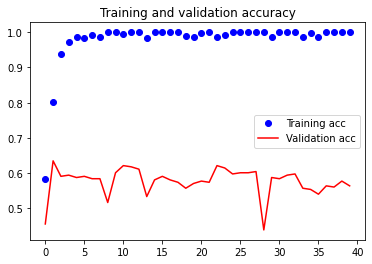

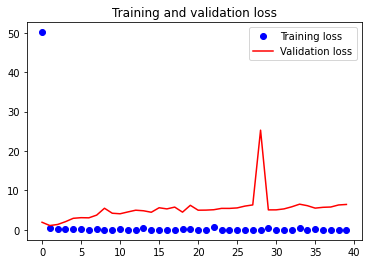

In [78]:
import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Confusion matrix, without normalization
[[574 349 194]
 [363 277 141]
 [299 188 100]]
              precision    recall  f1-score   support

       Fruit       0.46      0.51      0.49      1117
    Packages       0.34      0.35      0.35       781
  Vegetables       0.23      0.17      0.20       587

    accuracy                           0.38      2485
   macro avg       0.34      0.35      0.34      2485
weighted avg       0.37      0.38      0.37      2485



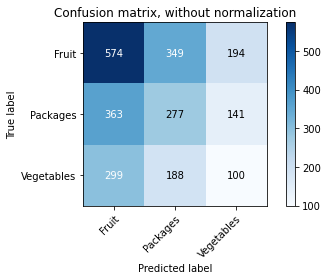

In [79]:
y_true = test_batches.labels
y_pred = model.predict_classes(test_batches)
classes = ['Fruit', 'Packages', 'Vegetables']

plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

print(classification_report(y_true, y_pred, target_names=classes))

### 3.2 Hacer Aumento de datos

Para el mismo modelo que armamos arriba (es decir, una vez que definan uno, se quedan con ese), hagamos un poco de aumento de cantidad de datos. Es una buena forma de tener más datos y prevenir también el overfitting. 

Se puede aumentar los datos con los generadores de entrenamiento. Se recomienta usar reescalamiento, recorte, zoom y espejado horizontal.

* reescalar los inputs de 0,255 a 0,1
* aplicar el rango de recorte (shear_range) para aplicar cortes aleatorios
* aplicar rango de zoom (zoom_range) para aplicar zoom aleatorio a las imágenes
* poner true el espejado horizontal (horizontal_flip) para obtener imágenes espejo horizontales)

Recuerden usar las mismas funciones de activación y optimización, para poder probar el mismo modelo.

Siempre recuerden plotear validación contra training para ver si hay overfitting.

Recuerden que hay que reescalar el test también, porque el modelo aprendió a utilizar los datos escalados

un buen lugar para consultar sobre Image Data Generator (la herramienta para aumentar los datos)
https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [80]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.5,
        zoom_range=0.5,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_2 = model.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=40,
        validation_data=validation_generator,
        validation_steps=steps_valid)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Epoch 1/40
53/52 [==============================] - 34s 642ms/step - loss: 0.7313 - acc: 0.6962 - val_loss: 0.9928 - val_acc: 0.5980
Epoch 2/40
53/52 [==============================] - 34s 639ms/step - loss: 0.6139 - acc: 0.7360 - val_loss: 0.9894 - val_acc: 0.6216
Epoch 3/40
53/52 [==============================] - 34s 643ms/step - loss: 0.5668 - acc: 0.7682 - val_loss: 0.7882 - val_acc: 0.6723
Epoch 4/40
53/52 [==============================] - 34s 640ms/step - loss: 0.5490 - acc: 0.7652 - val_loss: 0.7938 - val_acc: 0.6993
Epoch 5/40
53/52 [==============================] - 34s 641ms/step - loss: 0.5195 - acc: 0.7867 - val_loss: 0.7288 - val_acc: 0.6993
Epoch 6/40
53/52 [==============================] - 34s 642ms/step - loss: 0.4703 - acc: 0.8121 - val_loss: 0.7627 - val_acc: 0.6993
Epoch 7/40
53/52 [==============================] - 34s 639ms/step - loss: 0.4423 - acc: 0.8136 - val_loss: 0.8206 - va

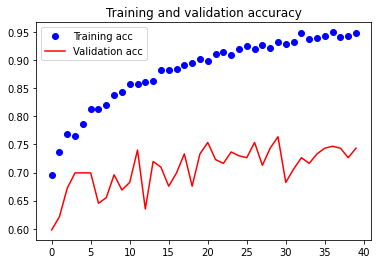

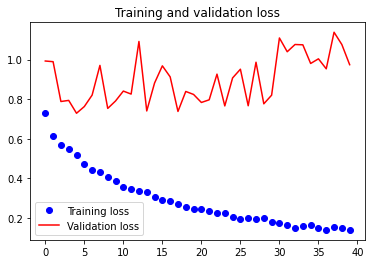

In [81]:
import matplotlib.pyplot as plt

acc = fit_generator_2.history['acc']
val_acc = fit_generator_2.history['val_acc']
loss = fit_generator_2.history['loss']
val_loss = fit_generator_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Normalized confusion matrix
[[0.27305282 0.59803044 0.12891674]
 [0.26760563 0.59795134 0.13444302]
 [0.27427598 0.5911414  0.13458262]]
              precision    recall  f1-score   support

       Fruit       0.45      0.27      0.34      1117
    Packages       0.32      0.60      0.41       781
  Vegetables       0.24      0.13      0.17       587

    accuracy                           0.34      2485
   macro avg       0.34      0.34      0.31      2485
weighted avg       0.36      0.34      0.32      2485



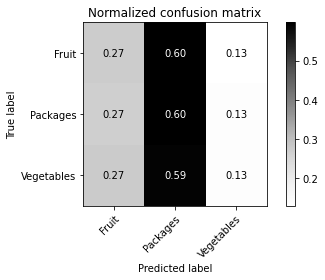

In [82]:
y_true = test_batches.labels
y_pred = model.predict_classes(test_batches)
classes = ['Fruit', 'Packages', 'Vegetables']

plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greys)

print(classification_report(y_true, y_pred, target_names=classes))

3.3 Más aumentos de imágenes 

Probemos agregar otros aumentos:

* rango de rotación (rotation_range) rota las imagenes.
* desplazar las imagenes aleatoriamente con (width_shift) en ancho
* desplazar las imagenes aleatoriamente con (height_shift) en ancho
* poner fill_mode en nearest para completar la imagen.


In [83]:
### Les dejo algo de código para que vayan empezando

train_datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.3,
        height_shift_range=0.3,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.5,
        zoom_range=0.5,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_2 = model.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=40,
        validation_data=validation_generator,
        validation_steps=steps_valid)


Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Epoch 1/40
53/52 [==============================] - 34s 646ms/step - loss: 0.4103 - acc: 0.8504 - val_loss: 0.7811 - val_acc: 0.7432
Epoch 2/40
53/52 [==============================] - 34s 643ms/step - loss: 0.3553 - acc: 0.8617 - val_loss: 0.7557 - val_acc: 0.7297
Epoch 3/40
53/52 [==============================] - 34s 646ms/step - loss: 0.3325 - acc: 0.8655 - val_loss: 0.6733 - val_acc: 0.7399
Epoch 4/40
53/52 [==============================] - 34s 646ms/step - loss: 0.3224 - acc: 0.8769 - val_loss: 0.7589 - val_acc: 0.7128
Epoch 5/40
53/52 [==============================] - 34s 650ms/step - loss: 0.3040 - acc: 0.8852 - val_loss: 0.6837 - val_acc: 0.7601
Epoch 6/40
53/52 [==============================] - 34s 650ms/step - loss: 0.2951 - acc: 0.8890 - val_loss: 0.5874 - val_acc: 0.7635
Epoch 7/40
53/52 [==============================] - 34s 650ms/step - loss: 0.2922 - acc: 0.8856 - val_loss: 0.9021 - va

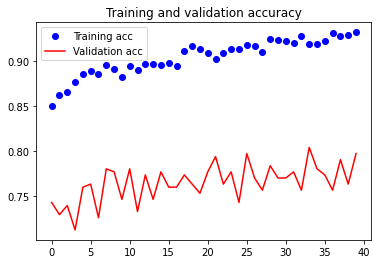

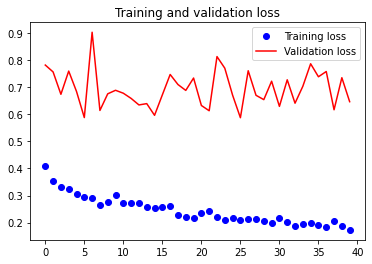

In [84]:
import matplotlib.pyplot as plt

acc = fit_generator_2.history['acc']
val_acc = fit_generator_2.history['val_acc']
loss = fit_generator_2.history['loss']
val_loss = fit_generator_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Confusion matrix, without normalization
[[451 560 106]
 [288 428  65]
 [200 325  62]]
              precision    recall  f1-score   support

       Fruit       0.48      0.40      0.44      1117
    Packages       0.33      0.55      0.41       781
  Vegetables       0.27      0.11      0.15       587

    accuracy                           0.38      2485
   macro avg       0.36      0.35      0.33      2485
weighted avg       0.38      0.38      0.36      2485



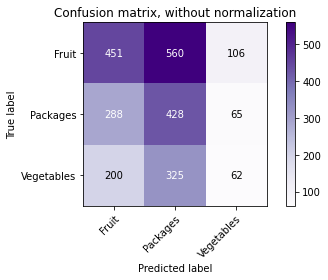

In [85]:
y_true = test_batches.labels
y_pred = model.predict_classes(test_batches)
classes = ['Fruit', 'Packages', 'Vegetables']

plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Purples)

print(classification_report(y_true, y_pred, target_names=classes))

### 3.3 Regularización: Añadir capa o capas de dropout para regularizar.


In [86]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.add(Dropout(0.3))
model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 86528)            

In [87]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_2 = model.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=40,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Epoch 1/40
53/52 [==============================] - 35s 655ms/step - loss: 0.2533 - acc: 0.4292 - val_loss: 1.1921e-07 - val_acc: 0.3750
Epoch 2/40
53/52 [==============================] - 36s 675ms/step - loss: 1.1921e-07 - acc: 0.4326 - val_loss: 1.1921e-07 - val_acc: 0.3750
Epoch 3/40
53/52 [==============================] - 36s 687ms/step - loss: 1.1921e-07 - acc: 0.4326 - val_loss: 1.1921e-07 - val_acc: 0.3750
Epoch 4/40
53/52 [==============================] - 36s 683ms/step - loss: 1.1921e-07 - acc: 0.4326 - val_loss: 1.1921e-07 - val_acc: 0.3750
Epoch 5/40
53/52 [==============================] - 36s 674ms/step - loss: 1.1921e-07 - acc: 0.4326 - val_loss: 1.1921e-07 - val_acc: 0.3750
Epoch 6/40
53/52 [==============================] - 36s 677ms/step - loss: 1.1921e-07 - acc: 0.4326 - val_loss: 1.1921e-07 - val_acc: 0.3750
Epoch 7/40
53/52 [==============================] - 36s 674ms/step - loss: 1.1921e-07 - acc: 0.4326 - val_loss: 1.1921e-07 - val_acc: 0.3750
Epoch 8/40
53/52 

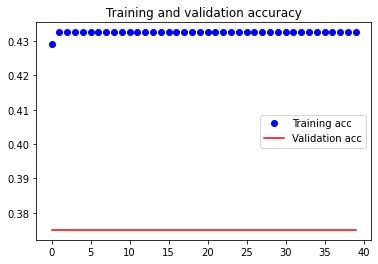

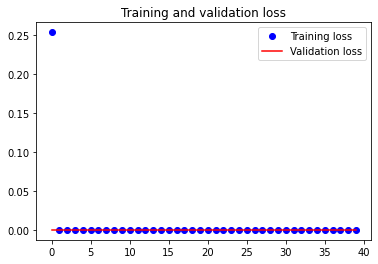

In [88]:
import matplotlib.pyplot as plt

acc = fit_generator_2.history['acc']
val_acc = fit_generator_2.history['val_acc']
loss = fit_generator_2.history['loss']
val_loss = fit_generator_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Confusion matrix, without normalization
[[1117    0    0]
 [ 781    0    0]
 [ 587    0    0]]
              precision    recall  f1-score   support

       Fruit       0.45      1.00      0.62      1117
    Packages       0.00      0.00      0.00       781
  Vegetables       0.00      0.00      0.00       587

    accuracy                           0.45      2485
   macro avg       0.15      0.33      0.21      2485
weighted avg       0.20      0.45      0.28      2485



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


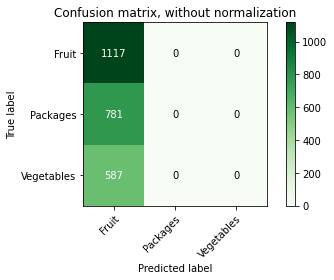

In [89]:
y_true = test_batches.labels
y_pred = model.predict_classes(test_batches)
classes = ['Fruit', 'Packages', 'Vegetables']

plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens)

print(classification_report(y_true, y_pred, target_names=classes))

# 4. Utilizar una Red Preentrenada y hacer Fine-Tuning!

Probar con VGG16, recortando las últimas capas de la red para hacer fine tuning. El que se anime, puede probar ResNet también que es una red con una arquitectura bastante más compleja!

Recuerden que tienen que setear cuáles serán las capas a entrenar.
Les dejo documentación al respecto! :)

https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [90]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

from keras.preprocessing import image
from keras import applications
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

In [91]:
#### Recuerden que aquí, cuando ya estén medio estables con los resultados, pueden empezar a jugar con los optimizadores y también realizar el aumento de imágenes para el modelo con vgg o resnet :)
#### SUERTE Y CUALQUIER COSA  ME PREGUNTAN!

In [92]:
from tensorflow.keras.applications import vgg16
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_conv.layers[:]:
  layer.trainable = False


model_1 = models.Sequential()
model_1.add(vgg_conv)

model_1.add(Flatten())
model_1.add(Dense(1024, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(3, activation='softmax'))

model_1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 25,694,211
Non-trainable params: 14,714,688
_________________________________________________________________


In [93]:
model_1.compile(loss='categorical_crossentropy',
	            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])

history = model_1.fit(
    train_batches,
    steps_per_epoch= steps_train,
    epochs=20,
	  validation_data=validation_generator,
    validation_steps= steps_valid,
    verbose=1)

Epoch 1/20
53/52 [==============================] - 7s 137ms/step - loss: 6.6719 - acc: 0.8249 - val_loss: 1.7131 - val_acc: 0.4155
Epoch 2/20
53/52 [==============================] - 7s 132ms/step - loss: 1.9301 - acc: 0.9226 - val_loss: 1.6127 - val_acc: 0.5338
Epoch 3/20
53/52 [==============================] - 7s 132ms/step - loss: 0.7666 - acc: 0.9599 - val_loss: 2.0684 - val_acc: 0.3885
Epoch 4/20
53/52 [==============================] - 7s 131ms/step - loss: 0.3890 - acc: 0.9786 - val_loss: 0.9846 - val_acc: 0.5169
Epoch 5/20
53/52 [==============================] - 7s 133ms/step - loss: 0.6121 - acc: 0.9670 - val_loss: 1.4239 - val_acc: 0.4899
Epoch 6/20
53/52 [==============================] - 7s 131ms/step - loss: 0.3556 - acc: 0.9786 - val_loss: 1.3685 - val_acc: 0.4358
Epoch 7/20
53/52 [==============================] - 7s 134ms/step - loss: 0.2045 - acc: 0.9870 - val_loss: 1.0385 - val_acc: 0.5338
Epoch 8/20
53/52 [==============================] - 7s 136ms/step - loss: 0.

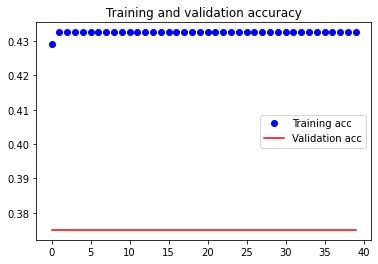

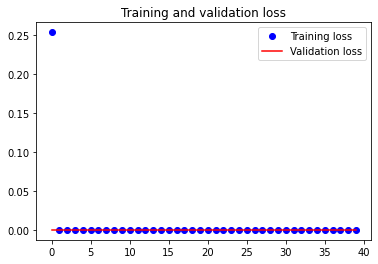

In [94]:
acc = fit_generator_2.history['acc']
val_acc = fit_generator_2.history['val_acc']
loss = fit_generator_2.history['loss']
val_loss = fit_generator_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Confusion matrix, without normalization
[[543 349 225]
 [353 244 184]
 [274 193 120]]
              precision    recall  f1-score   support

       Fruit       0.46      0.49      0.47      1117
    Packages       0.31      0.31      0.31       781
  Vegetables       0.23      0.20      0.22       587

    accuracy                           0.36      2485
   macro avg       0.33      0.33      0.33      2485
weighted avg       0.36      0.36      0.36      2485



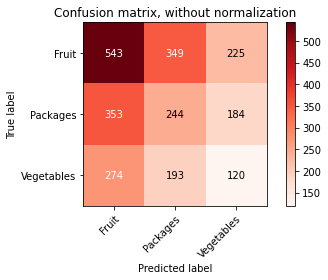

In [95]:
y_true = test_batches.labels
y_pred = model_1.predict_classes(test_batches)
classes = ['Fruit', 'Packages', 'Vegetables']

plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds)
print(classification_report(y_true, y_pred, target_names=classes))